# 使用卷积神经网络 `CNN` 的手写识别——改进 

## 下面这些保持不变

In [1]:
from typing import override
from pathlib import Path
from pickle import load, dump

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.sgd import SGD

import matplotlib.pyplot as plt

In [2]:
class MnistDataset2D(Dataset):
    @override
    def __init__(self, x:torch.Tensor, y:torch.Tensor) -> None:
        super().__init__()
        if len(x) != len(y):
            raise IndexError('len(x) != len(y)')
        self.x = x
        self.y = y
        return
    
    @override
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        return self.x[index].unsqueeze(0), self.y[index]
    
    @override
    def __len__(self) -> int:
        return len(self.x)
    
    
def readDataset(name:str) -> MnistDataset2D:
    fullImgPath = f'./mnistData/{name}-images.idx3-ubyte'
    fullLabelPath = f'./mnistData/{name}-labels.idx1-ubyte'

    with open(fullImgPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2051:
            raise ValueError(f'head magic number not equal to 2051: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        dataRow = int.from_bytes(f.read(4))
        dataCol = int.from_bytes(f.read(4))
        
        img = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber*dataRow*dataCol,
            offset=0,
            )
    img.shape = (dataNumber, dataRow, dataCol)
    imgTensor = torch.from_numpy(img).type(torch.float32) / 255
        
    with open(fullLabelPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2049:
            raise ValueError(f'head magic number not equal to 2049: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        
        label = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber,
            offset=0,
            )

    labelOnehotTensor = torch.zeros((len(label), 10), dtype=torch.float32)
    for i,j in zip(label, labelOnehotTensor):
        j[i] = 1
    
    return MnistDataset2D(imgTensor, labelOnehotTensor)

---

## 卷积的模型

上一小结里，我们将第一层由全连接层替换为卷积层+池化层

这里尝试将第二次进行修改

在第一层和第二层之间再加入一层卷积

In [3]:
model = nn.Sequential(

    nn.Conv2d(1, 8, 3, 1, 1, dtype=torch.float32),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(8, 64, 3, 1, 1, dtype=torch.float32),
    nn.MaxPool2d(2),
    nn.Flatten(1,3),
    nn.ReLU(),
    nn.Linear(7 * 7 * 8 * 8, 32, True, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(32, 16, True, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(16, 10, True, dtype=torch.float32),
)

def predict(input):
    return torch.softmax(model(input), dim=1)

criterion = nn.CrossEntropyLoss()
optimisor = SGD(model.parameters(), lr=0.01, weight_decay=0.001)

## 加载训练数据集

In [4]:

trainSetPath = Path("./trainDataset2D.pickle")

if trainSetPath.exists():
    with open(trainSetPath, "rb") as f:
        trainSet = load(f)
else:
    trainSet = readDataset("train")
    with open(trainSetPath, "wb") as f:
        dump(trainSet, f)

trainDataLoader = DataLoader(trainSet, 20, True)

## 加载已有模型

In [5]:

modelFile = Path("./modelWithCNN.pickle")

if modelFile.exists():
    with open(modelFile, "rb") as f:
        model = load(f)
    print(f"已加载已有模型：{modelFile}")


In [ ]:

epochs = 10
for epoch in range(epochs):
    for i, data in enumerate(trainDataLoader):
        output = model(data[0])
        loss: torch.Tensor = criterion(output, data[1])
        optimisor.zero_grad()
        loss.backward()
        optimisor.step()
        if (i + 1) % 100 == 0:
            print(f"loss:{float(loss)}")
    for i in optimisor.param_groups:
        i["lr"] *= 0.3

print("训练完成")

with open(modelFile, "wb") as f:
    dump(model, f)

## 对训练结果进行测试

上一次将第一次改为卷积层，正确率在93%左右，即错误率大约为7%

现在将第二次替换为卷积层，正确率可以超过96%，即错误率不到4%

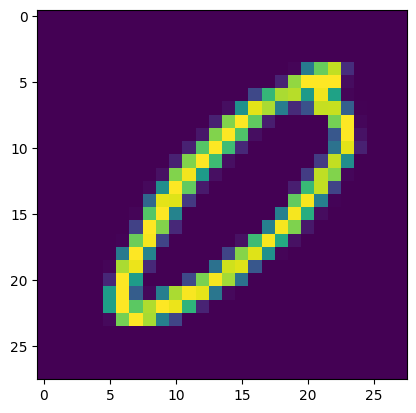

Target: 0
Predict: 0
tensor([True])
--------------------


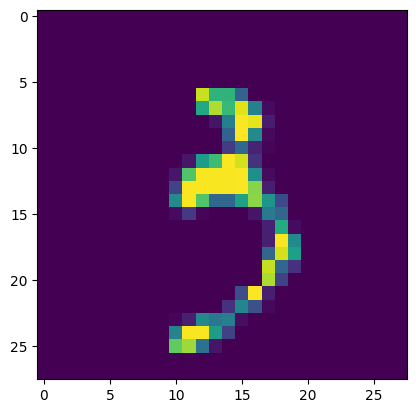

Target: 3
Predict: 3
tensor([True])
--------------------


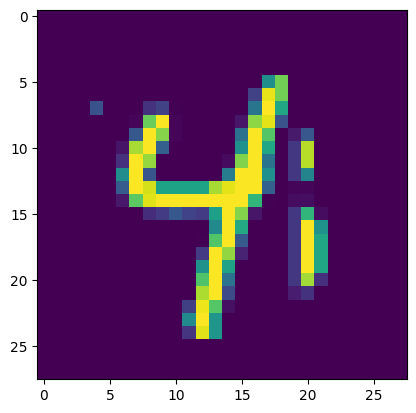

Target: 4
Predict: 4
tensor([True])
--------------------


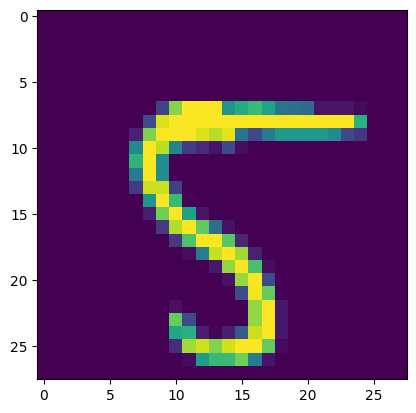

Target: 5
Predict: 5
tensor([True])
--------------------


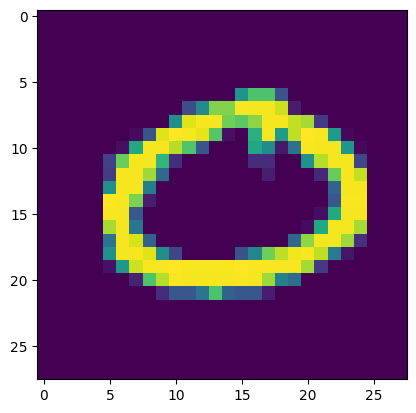

Target: 0
Predict: 0
tensor([True])
--------------------


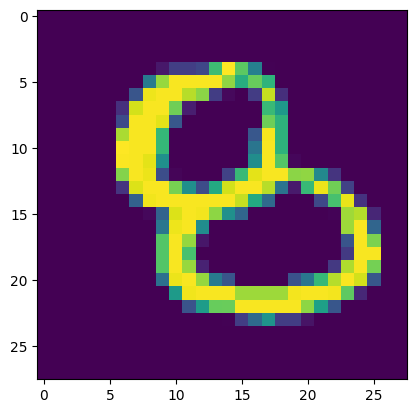

Target: 8
Predict: 8
tensor([True])
--------------------


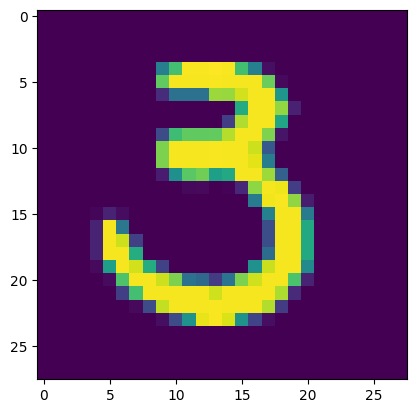

Target: 3
Predict: 3
tensor([True])
--------------------


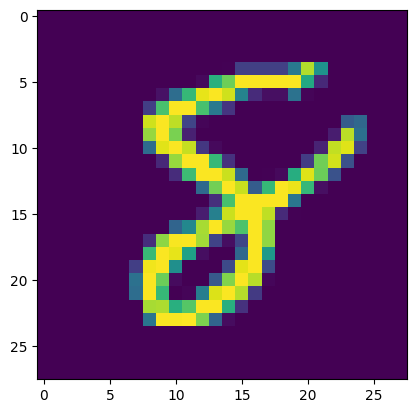

Target: 8
Predict: 8
tensor([True])
--------------------


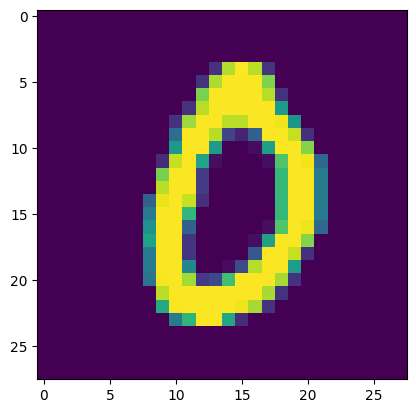

Target: 0
Predict: 0
tensor([True])
--------------------


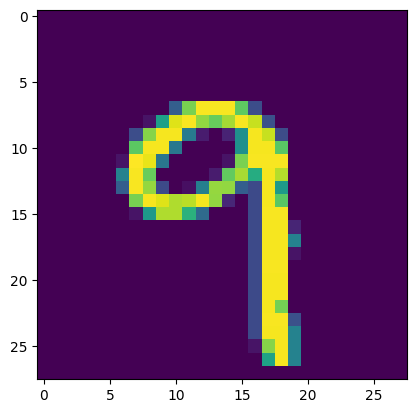

Target: 9
Predict: 9
tensor([True])
--------------------
正确率96.19%


In [7]:
testSet = readDataset("t10k")
testDataLoader = DataLoader(testSet, batch_size=1, shuffle=True)

showCount = 0

correctorchount = 0
for data in testDataLoader:
    output: torch.Tensor = model(data[0])
    correction: torch.Tensor = output.argmax(1) == data[1].argmax(1)
    correctorchount += int(correction.sum(dtype=torch.int32))
    if showCount < 10:
        showCount += 1
        plt.imshow(data[0].reshape((28,28)))
        plt.show()
        print(f'Target: {data[1].argmax()}')
        print(f'Predict: {output.argmax()}')
        print(correction)
        print('-'*20)


print(f"正确率{correctorchount/100}%")